import yaml

from torchrl.envs.utils import check_env_specs

from config import TrainingConfig, LossConfig, AgentNNConfig, BackboneConfig, HeadConfig, EnvConfig
from algorithms.simple_nn import TrainableNNAgentPolicy
from algorithms.generic_policy import MultiAgentPolicy
from algorithms.generator import AgentGenerator
from algorithms.keys_processors import CombinedExtractor

with open("configs/run/test_single_training_flipit_transformer.yaml", "r") as file:
    config = yaml.safe_load(file)
env_config = EnvConfig.from_dict(config)

env_map, env = env_config.create("cuda")
check_env_specs(env)

In [2]:
training_config_defender = TrainingConfig.from_dict(config, suffix="_defender")
loss_config_defender = LossConfig.from_dict(config, suffix="_defender")
training_config_attacker = TrainingConfig.from_dict(config, suffix="_attacker")
loss_config_attacker = LossConfig.from_dict(config, suffix="_attacker")
agent_config = AgentNNConfig.from_dict(config)
backbone_config = BackboneConfig.from_dict(config, suffix="_backbone")
head_config = HeadConfig.from_dict(config, suffix="_head")

defender_extractor = CombinedExtractor(player_type=0, env=env, actions_map=backbone_config.extractors)
defender_agent_transformer = TrainableNNAgentPolicy(
    player_type=0,
    max_sequence_size=env_config.num_steps + 1,
    extractor=defender_extractor,
    action_size=env.action_size,
    env_type=env_config.env_pair,
    agent_config=agent_config,
    backbone_config=backbone_config,
    head_config=head_config,
    device="cuda:0",
    loss_config=loss_config_defender,
    training_config=training_config_defender,
    run_name="test",
)
defender_agent_transformer.eval()
defender_agent_transformer.load("saved_models/2025-06-10_13:18:36-full-transformer/defender/agent_0.pth")

attacker_extractor = CombinedExtractor(player_type=1, env=env, actions_map=backbone_config.extractors)
attacker_agent_transformer = MultiAgentPolicy(
    action_size=env.action_size,
    player_type=1,
    device="cuda",
    embedding_size=agent_config.embedding_size,
    run_name="test",
    policy_generator=AgentGenerator(
        TrainableNNAgentPolicy,
        {
            "extractor": attacker_extractor,
            "max_sequence_size": env_config.num_steps + 1,
            "action_size": env.action_size,
            "env_type": env_config.env_pair,
            "player_type": 1,
            "device": "cuda",
            "loss_config": loss_config_attacker,
            "training_config": training_config_attacker,
            "run_name": "test",
            "agent_config": agent_config,
            "backbone_config": backbone_config,
            "head_config": head_config,
        }
    ),
)
attacker_agent_transformer.eval()
attacker_agent_transformer.load("saved_models/2025-06-10_13:18:36-full-transformer/attacker")

In [3]:
with open("configs/run/test_single_training_flipit.yaml", "r") as file:
    config = yaml.safe_load(file)
training_config_defender = TrainingConfig.from_dict(config, suffix="_defender")
loss_config_defender = LossConfig.from_dict(config, suffix="_defender")
training_config_attacker = TrainingConfig.from_dict(config, suffix="_attacker")
loss_config_attacker = LossConfig.from_dict(config, suffix="_attacker")
agent_config = AgentNNConfig.from_dict(config)
backbone_config = BackboneConfig.from_dict(config, suffix="_backbone")
head_config = HeadConfig.from_dict(config, suffix="_head")

defender_extractor_ffn = CombinedExtractor(player_type=0, env=env, actions_map=backbone_config.extractors)
defender_agent_ffn = TrainableNNAgentPolicy(
    player_type=0,
    max_sequence_size=env_config.num_steps + 1,
    extractor=defender_extractor_ffn,
    action_size=env.action_size,
    env_type=env_config.env_pair,
    device="cuda:0",
    loss_config=loss_config_defender,
    training_config=training_config_defender,
    run_name="test",
    agent_config=agent_config,
    backbone_config=backbone_config,
    head_config=head_config,
)
defender_agent_ffn.eval()
defender_agent_ffn.load("saved_models/2025-06-10_13:18:36-full-fnn/defender/agent_0.pth")

attacker_extractor_ffn = CombinedExtractor(player_type=1, env=env, actions_map=backbone_config.extractors)
attacker_agent_ffn = MultiAgentPolicy(
    action_size=env.action_size,
    player_type=1,
    device="cuda:0",
    embedding_size=agent_config.embedding_size,
    run_name="test",
    policy_generator=AgentGenerator(
        TrainableNNAgentPolicy,
        {
            "extractor": attacker_extractor_ffn,
            "max_sequence_size": env_config.num_steps + 1,
            "action_size": env.action_size,
            "env_type": env_config.env_pair,
            "player_type": 1,
            "device": "cuda:0",
            "loss_config": loss_config_attacker,
            "training_config": training_config_attacker,
            "run_name": "test",
            "agent_config": agent_config,
            "backbone_config": backbone_config,
            "head_config": head_config,
        }
    ),
)
attacker_agent_ffn.eval()
attacker_agent_ffn.load("saved_models/2025-06-10_13:18:36-full-fnn/attacker")

In [4]:
from algorithms.coevosg import CoevoSGDefenderAgent, CoevoSGAttackerAgent, CoevoSGConfig

defender_agent_coevosg = CoevoSGDefenderAgent(
    device="cpu",
    run_name="test",
    config=CoevoSGConfig(),
    env=env,
)

attacker_agent_coevosg = CoevoSGAttackerAgent(
    device="cpu",
    run_name="test",
    config=CoevoSGConfig(),
    env=env,
)

defender_agent_coevosg.eval()
attacker_agent_coevosg.eval()
defender_agent_coevosg.load("saved_models/2025-06-11_10:38:51-full-coevosg-/defender/agent_0.pth")
attacker_agent_coevosg.load("saved_models/2025-06-11_10:38:51-full-coevosg-/attacker/agent_0.pth")

In [5]:
from algorithms.generic_policy import RandomAgent, GreedyOracleAgent, FlipItLogicModule

attacker_agent_random = RandomAgent(action_size=env.action_size, embedding_size=agent_config.embedding_size, player_type=1, device="cuda:0", run_name="test")

logic_module = FlipItLogicModule(env_map=env_map, player_type=1, total_steps=env.num_steps, device="cuda:0")
attacker_greedy_oracle = GreedyOracleAgent(
    action_size=env.action_size, total_steps=env.num_steps, embedding_size=agent_config.embedding_size, player_type=1, device="cuda:0", run_name="test", map_logic=logic_module
)

In [6]:
from utils import compare_agent_pairs

results = compare_agent_pairs(
    [
        (defender_agent_transformer, attacker_agent_transformer, "transformer"),
        (defender_agent_ffn, attacker_agent_ffn, "nn"),
        (defender_agent_coevosg, attacker_agent_coevosg, "coevosg"),
    ],
    [
        (attacker_agent_random, "random"),
        (attacker_greedy_oracle, "greedy"),
    ],
    env,
    print_results=True,
)

Defender: transformer vs Attacker: transformer => Defender avg reward: 375.3127 (13.5074)
Defender: transformer vs Attacker: nn => Defender avg reward: 387.8731 (3.5768)
Defender: transformer vs Attacker: coevosg => Defender avg reward: 312.4338 (0.0000)
Defender: transformer vs Attacker: random => Defender avg reward: 381.4695 (7.2702)
Defender: transformer vs Attacker: greedy => Defender avg reward: 383.3600 (0.0000)
Defender: transformer => Avg reward: 368.0898 (29.0082)
Defender: nn vs Attacker: transformer => Defender avg reward: 381.1056 (13.6121)
Defender: nn vs Attacker: nn => Defender avg reward: 388.1829 (5.3775)
Defender: nn vs Attacker: coevosg => Defender avg reward: 309.4482 (0.0000)
Defender: nn vs Attacker: random => Defender avg reward: 389.4729 (7.7992)
Defender: nn vs Attacker: greedy => Defender avg reward: 334.8117 (0.0000)
Defender: nn => Avg reward: 360.6043 (33.4064)
Defender: coevosg vs Attacker: transformer => Defender avg reward: 370.3342 (9.5965)
Defender: c

In [19]:
# plot density of results
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
def plot_density(results, titles):
    plt.figure(figsize=(10, 6))
    for result, title in zip(results, titles):
        sns.kdeplot(data=result, fill=True, label=title)
    plt.title("Comparison of reward distributions (FlipIt)")
    plt.xlabel("Reward")
    plt.ylabel("Density")
    plt.legend()
    #plt.xlim(-1, 1)
    #plt.ylim(0, 5)
    plt.grid()
    plt.show()
    
def get_data(results, key):
    out = []
    for k in results:
        if k.startswith(f"{key}/") and k.endswith("/raw"):
            out.extend(results[k])
    return out

def get_data_specific(results, key1, key2):
    out = []
    for k in results:
        if k.startswith(f"{key1}/{key2}/") and k.endswith("/raw"):
            out.extend(results[k])
    return out

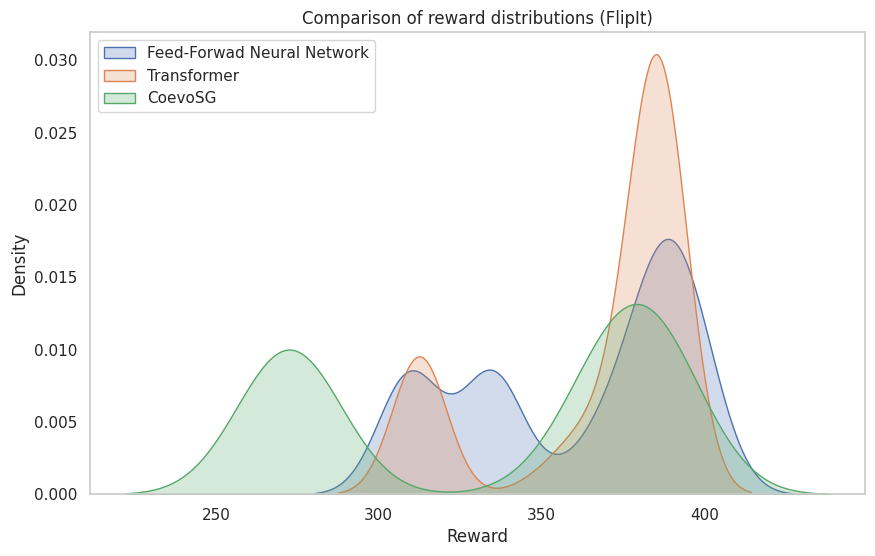

In [20]:
plot_density(
    [
        get_data(results, "nn"),
        get_data(results, "transformer"),
        get_data(results, "coevosg"),
    ],
    [
        "Feed-Forwad Neural Network",
        "Transformer",
        "CoevoSG",
    ],
)

In [9]:
import numpy as np
from scipy.stats import wilcoxon

def compare_models(model1, model2, print_results=True):
    data1 = get_data(results, model1)
    data2 = get_data(results, model2)
    
    if len(data1) != len(data2):
        raise ValueError("Data lengths do not match for comparison.")
    
    stat, p_value = wilcoxon(np.array(data1) - np.array(data2), alternative="greater")
    if print_results:
        print(f"Wilcoxon test between {model1} and {model2}: statistic={stat:.3f}, p-value={p_value:.3f}")
        
        if p_value < 0.05:
            print(f"Result: {model1} is statistically significantly better than {model2}.")
        else:
            print(f"Result: {model1} is not statistically significantly better than {model2}.")
        
    return p_value
    

In [15]:
# Use Holm-Bonferroni correction for multiple comparisons
from statsmodels.stats.multitest import multipletests
def holm_bonferroni_correction(p_values):
    corrected = multipletests(p_values, method='holm')
    return corrected[1]  # Return the corrected p-values

def compare_many_models(compared_model):
    models_to_compare = [
        "nn", "transformer", "coevosg"
    ]
    models_without_the_model = [model for model in models_to_compare if model != compared_model]
    p_values = [compare_models(compared_model, model, print_results=False) for model in models_without_the_model]

    corrected_p_values = holm_bonferroni_correction(p_values) 
    print(f"{compared_model} vs others p-values:")
    for model, p_value, org_p_value in zip(models_without_the_model, corrected_p_values, p_values):
        print(f"{model}: {p_value:.5f}({org_p_value:.5f}) - {'Significantly' if p_value < 0.05 else 'Not significantly'} better")

In [16]:
compare_many_models("transformer")

transformer vs others p-values:
nn: 0.00195(0.00195) - Significantly better
coevosg: 0.00000(0.00000) - Significantly better


In [17]:
compare_many_models("nn")

nn vs others p-values:
transformer: 0.99805(0.99805) - Not significantly better
coevosg: 0.00000(0.00000) - Significantly better


In [18]:
compare_many_models("coevosg")

coevosg vs others p-values:
nn: 1.00000(1.00000) - Not significantly better
transformer: 1.00000(1.00000) - Not significantly better
